# 0.0 Imports

In [2]:
import pandas as pd
import inflection 
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import random
import pickle
#import warning
import xgboost as xgb
    
from boruta import BorutaPy    
from scipy import stats
from tabulate import tabulate
from IPython.core.display import HTML
from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

#warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [5]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2cor = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcor = k - (k-1)**2/(n-1)
    rcor = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2cor/n) / (min(kcor-1,rcor-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

def mean_percentage_error(y, yhat):
    return np.mean((y-yhat)/y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y,yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

import random

Populating the interactive namespace from numpy and matplotlib


C:\Users\bruno\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [6]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on='Store')

# 1.0 Data description

In [7]:
df1 = df_raw.copy()

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1  Rename Columns

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2  Data Dimensions

In [10]:
print('Number of Rows: {}'. format(df1.shape[0]))
print('Number of Columns: {}'. format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
576576,907,5,2014-01-31,5597,812,1,0,0,0,a,c,250.0,NaN,NaN,0,NaN,NaN,NaN
131532,1078,7,2015-04-05,0,0,0,0,0,0,d,c,670.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
99176,1057,1,2015-05-04,7813,725,1,1,0,0,d,c,3230.0,11.0,2011.0,0,NaN,NaN,NaN
740066,492,5,2013-09-06,5562,952,1,0,0,1,a,a,1740.0,3.0,2008.0,1,40.0,2012.0,"Jan,Apr,Jul,Oct"
403270,551,7,2014-07-06,0,0,0,0,0,0,a,c,2190.0,9.0,2013.0,0,NaN,NaN,NaN


In [16]:
#competition_distance 
df1.competition_distance.fillna(200000., inplace=True)   

#competition_open_since_month 
df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

#competition_open_since_year
df1.competition_open_since_year.fillna(df1.date.dt.year, inplace=True)

#promo2_since_week
df1.promo2_since_week.fillna(df1.date.dt.week, inplace=True)

#promo2_since_year
df1.promo2_since_year.fillna(df1.date.dt.year, inplace=True)

#promo_interval   
df1['promo_interval'].fillna('', inplace=True) 

# obtem a abreviatura do mês
df1['month_map'] = df1['date'].dt.strftime("%b") 

# como não tem 0's mais, tudo vai ser string, então podemos remover aqueles if's
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: x['month_map'] in x['promo_interval'].split( ',' ), axis='columns').astype('int')

In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

df1['is_promo'] = df1['is_promo'].astype('int64')

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [20]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [21]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


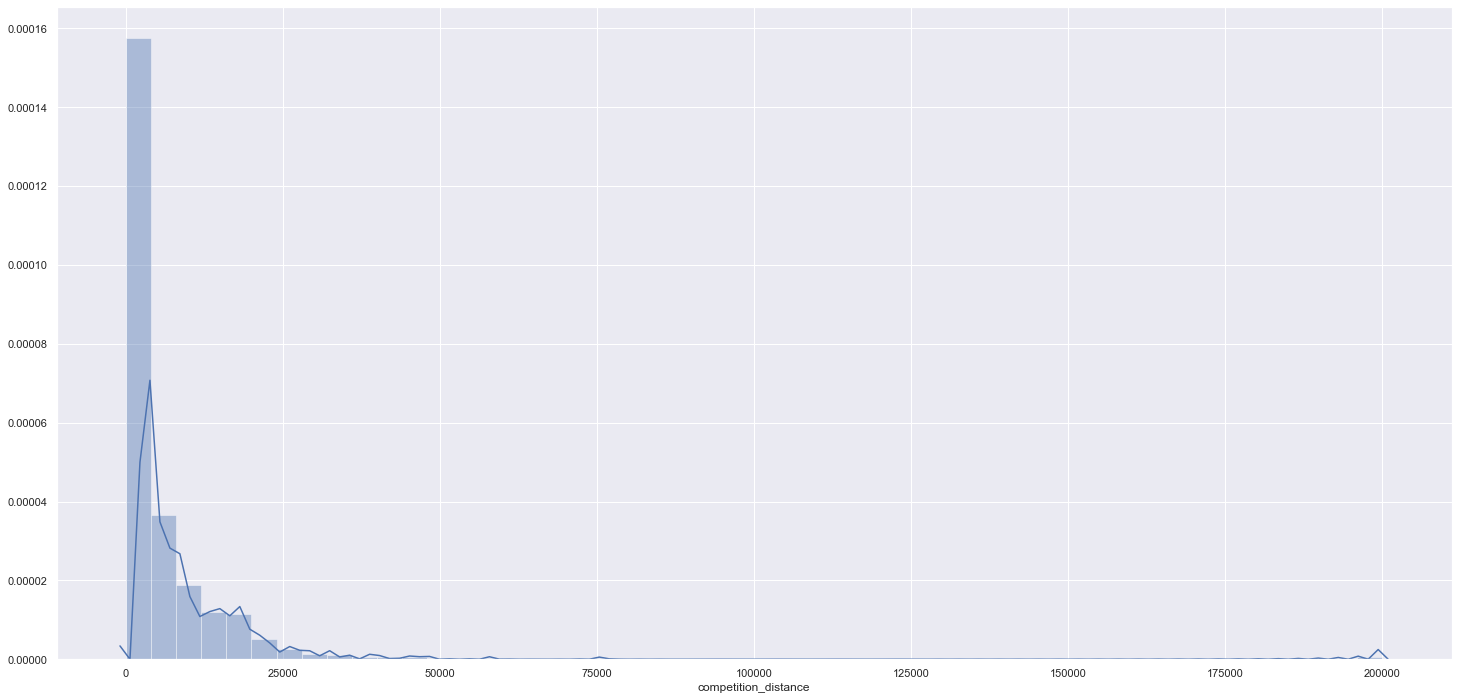

In [22]:
sns.distplot(df1['competition_distance'])

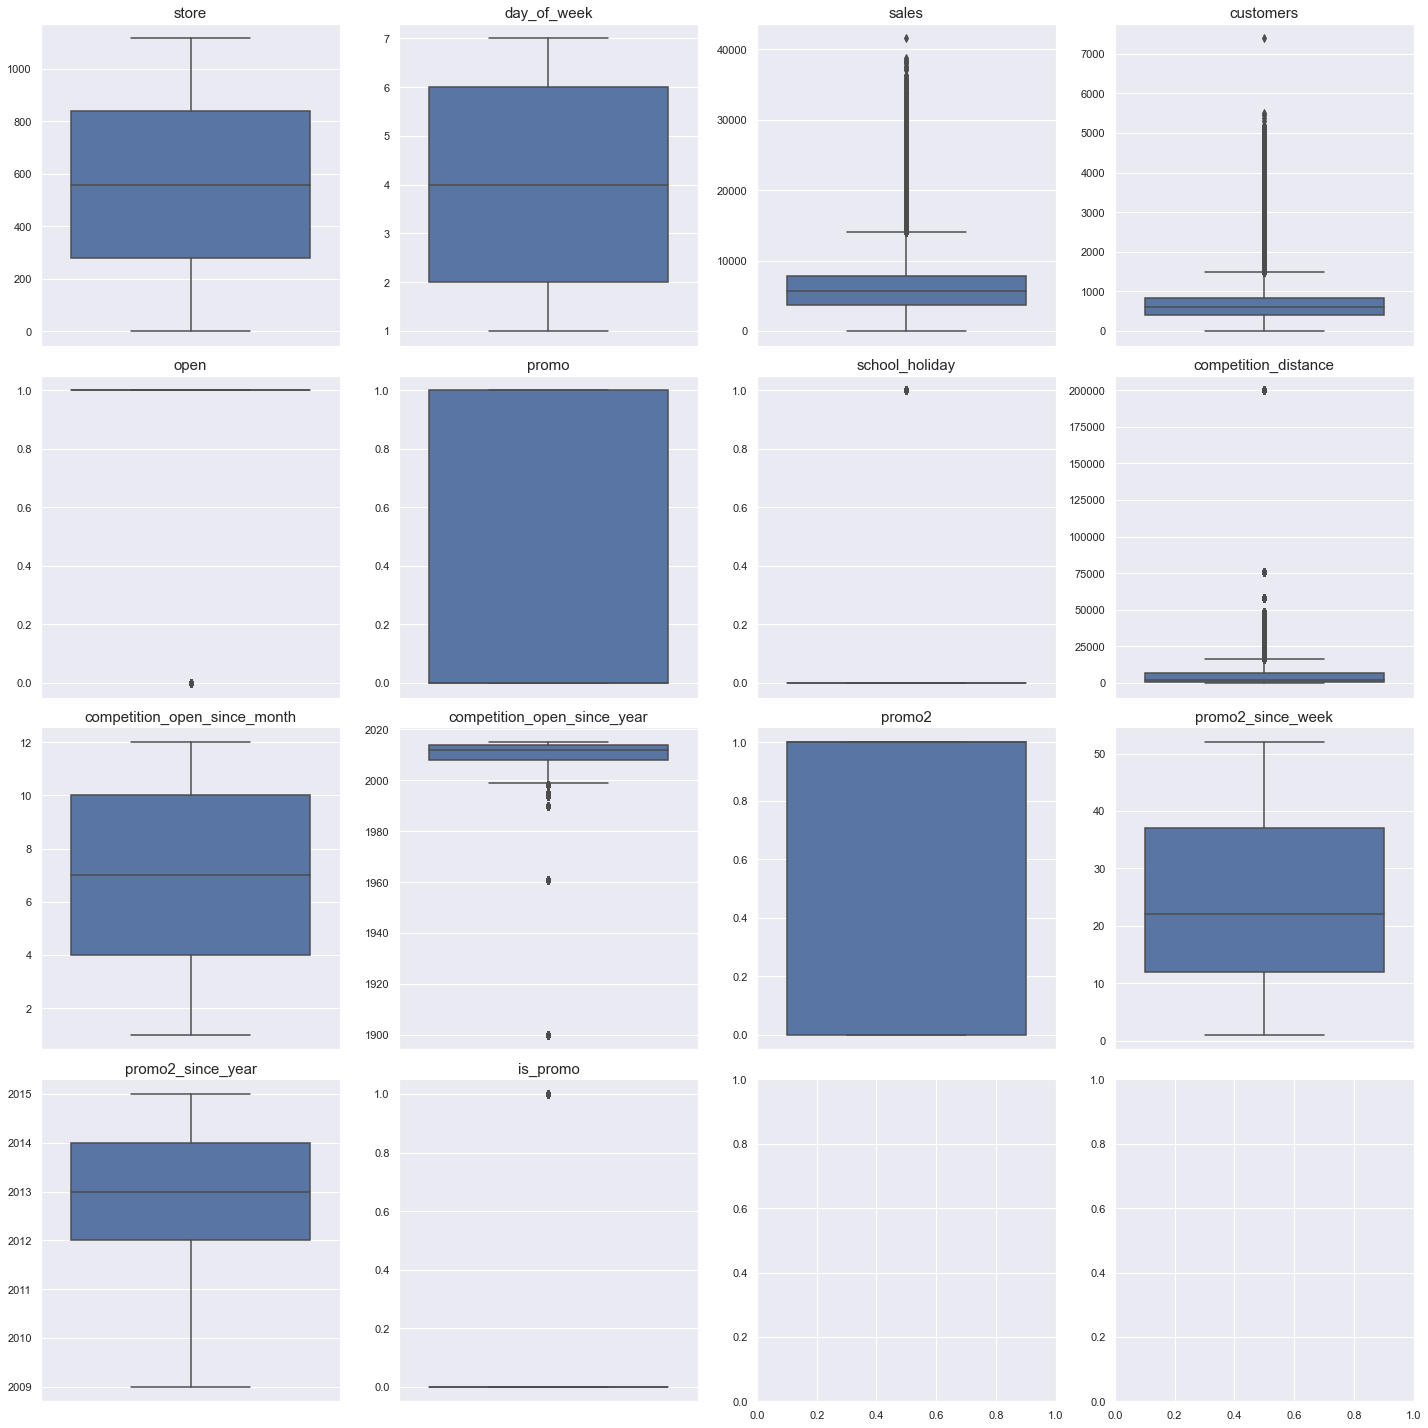

In [23]:
variables = num_attributes.columns.tolist()

f, axes = plt.subplots(4, 4, figsize = (20, 20))
for var, ax in zip(variables, f.axes):

  b = sns.boxplot(y = var, data = num_attributes, ax = ax)
  b.axes.set_title(var,fontsize = 15)
  b.set_ylabel("")

plt.tight_layout()
plt.show()

### 1.7.2 Categorical Attributes 

In [24]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

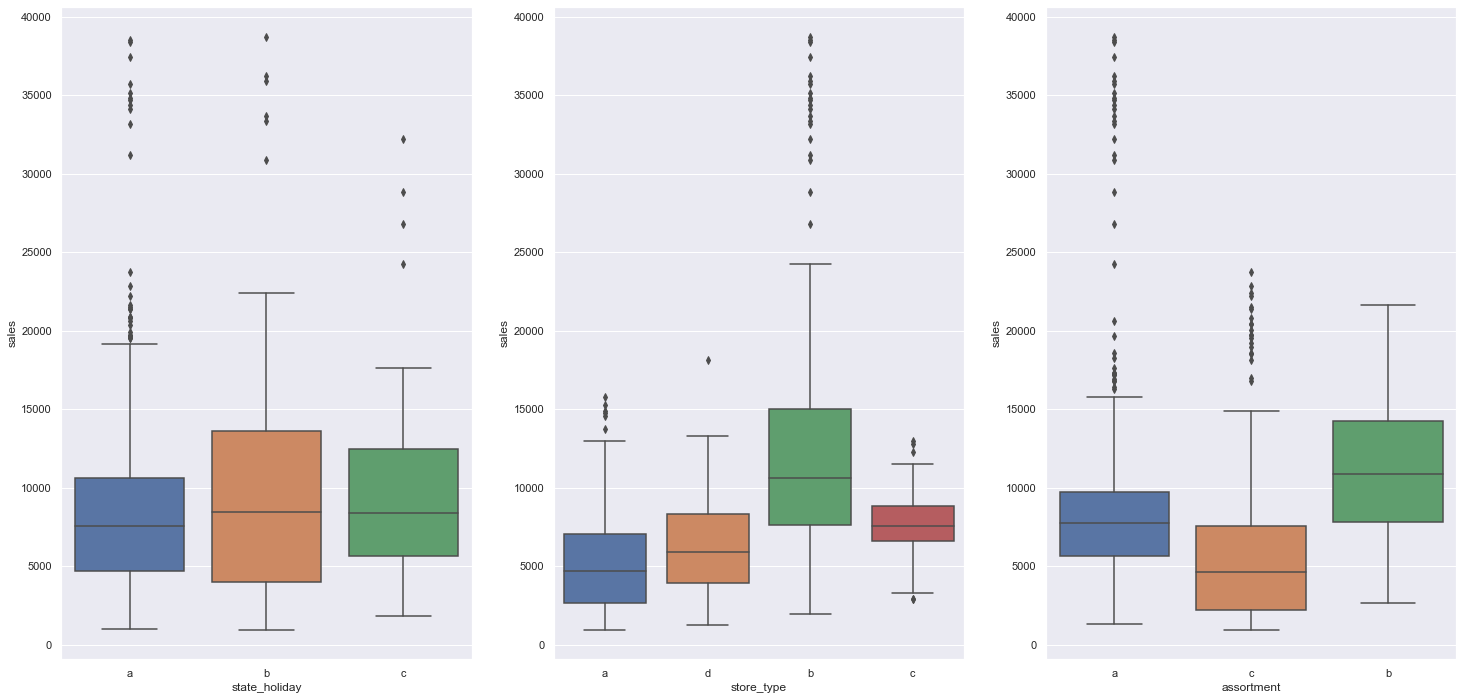

In [25]:
aux1 = df1[(df1['state_holiday'] !='0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0 Feature Engineering

In [26]:
df2 = df1.copy()

## 2.1 Hypothesis mind map

<img src="img/MindMapHypotesis_.png">

## 2.2 Hypotheses Creation

### 2.2.1 Store

**1.** Stores with a larger workforce should sell more.

**2.** Stores with a larger inventory should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with more distant competitors should sell more.

**6.** Stores with older competitors should sell more.

### 2.2.2 Product

**1.** Stores that invest more in marketing should sell more.

**2.** Stores that exhibit more products in store windows should sell more.

**3.** Stores that have less product prices should sell more.

**4.** Stores that have lower prices on products for a longer time should sell more.

**5.** Stores with more aggressive promotions (bigger discounts) should sell more.

**6.** Stores with active promotions for longer should sell more.

**7.** Stores with more promotion days should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.2.3 Time

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month

**5.** Stores should sell less on weekends

**6.** Stores should sell less during school holidays

## 2.3 Final hypotheses list

The hypotheses were chosen based on the data that have already been obtained and can be used for study. For other hypotheses to be tested, there needs to be a greater collection of data from different areas of the company.

**1.** Stores with a larger assortment should sell more.

**2.** Stores with more distant competitors should sell more.

**3.** Stores with older competitors should sell more.

**4.** Stores with active promotions for a longer time should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month

**11.** Stores should sell less on weekends

## 2.4 Feature Engineering

In [27]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since']=df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1),axis =1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since'])/7 ).apply(lambda x: x.days).astype('int64')

# assortment 
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x =='a' else 'extra' if x =='b' else 'extended' )
 
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x =='b' else 'christmas' if x =='c' else 'regular_day')



In [28]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Variable filtering

In [29]:
df3 = df2.copy()

In [30]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Line filtering

In [31]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
# the rows whose open column is equal to zero have been removed, as they do not contribute to obtaining knowledge of the data.

## 3.2 Column selection

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop,axis = 1)

# There is no costumer data at the time of prediction, it is a business restriction.

In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Exploratory data analysis

In [34]:
df4 = df3.copy() 

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

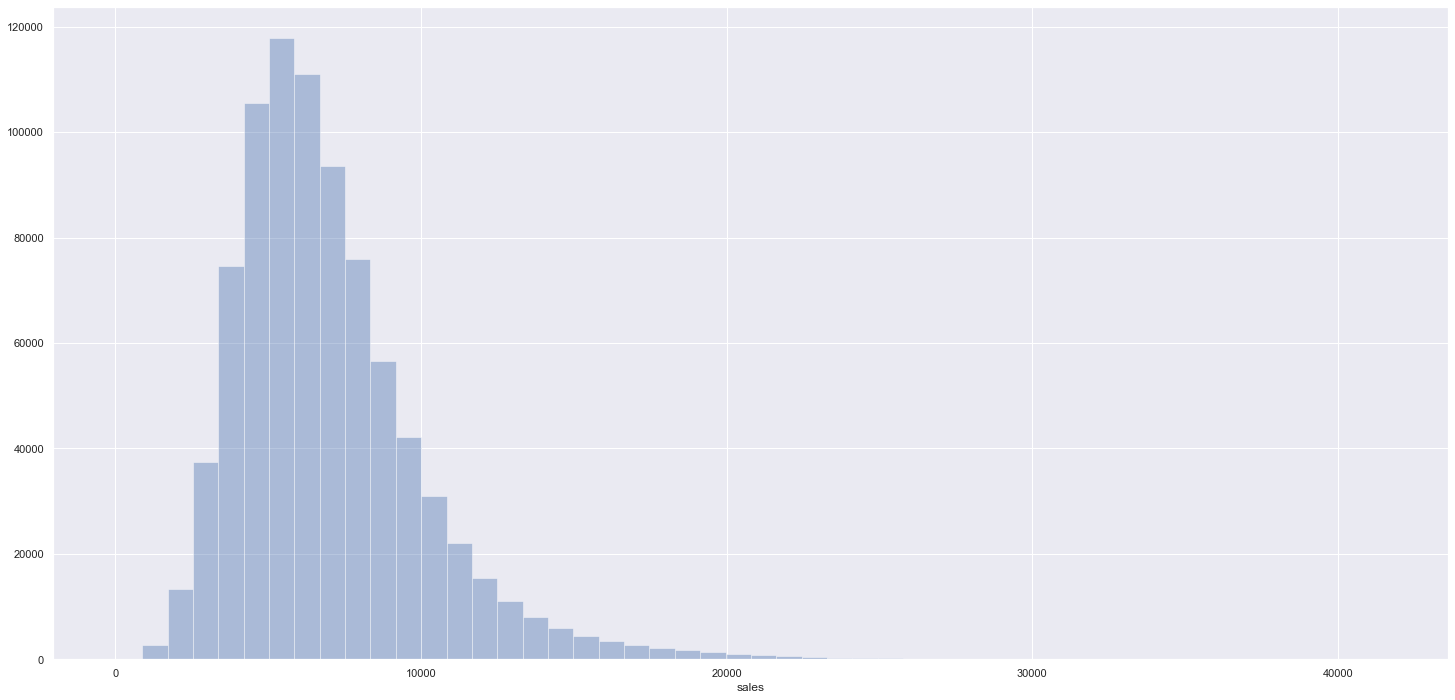

In [35]:
sns.distplot(df4['sales'], kde =False)

# the more normal the distribution, the better the machine learning models

### 4.1.2 Numerical Variable

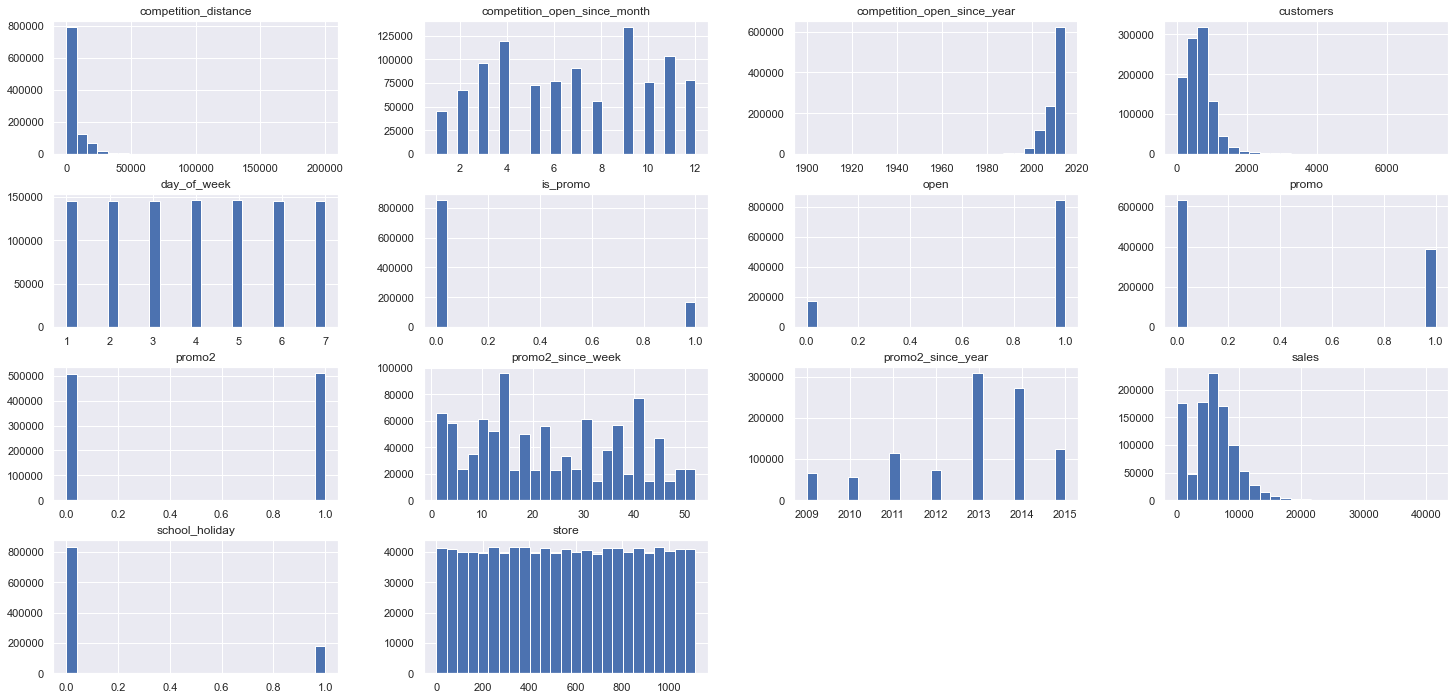

In [36]:
num_attributes.hist(bins = 25);

### 4.1.3 Categorical Variable

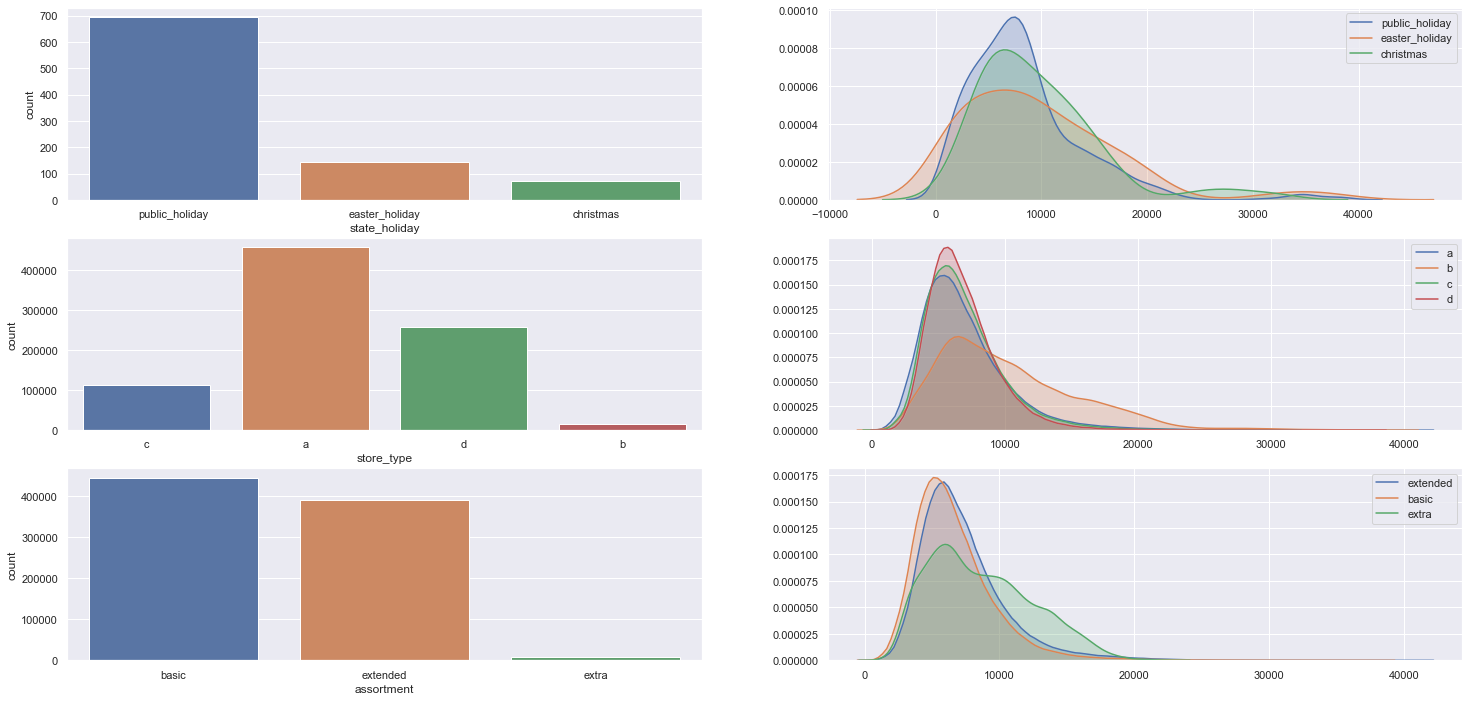

In [37]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)

## 4.2 Bivariate analysis

### **H1** Stores with a larger assortment should sell more.
**True**


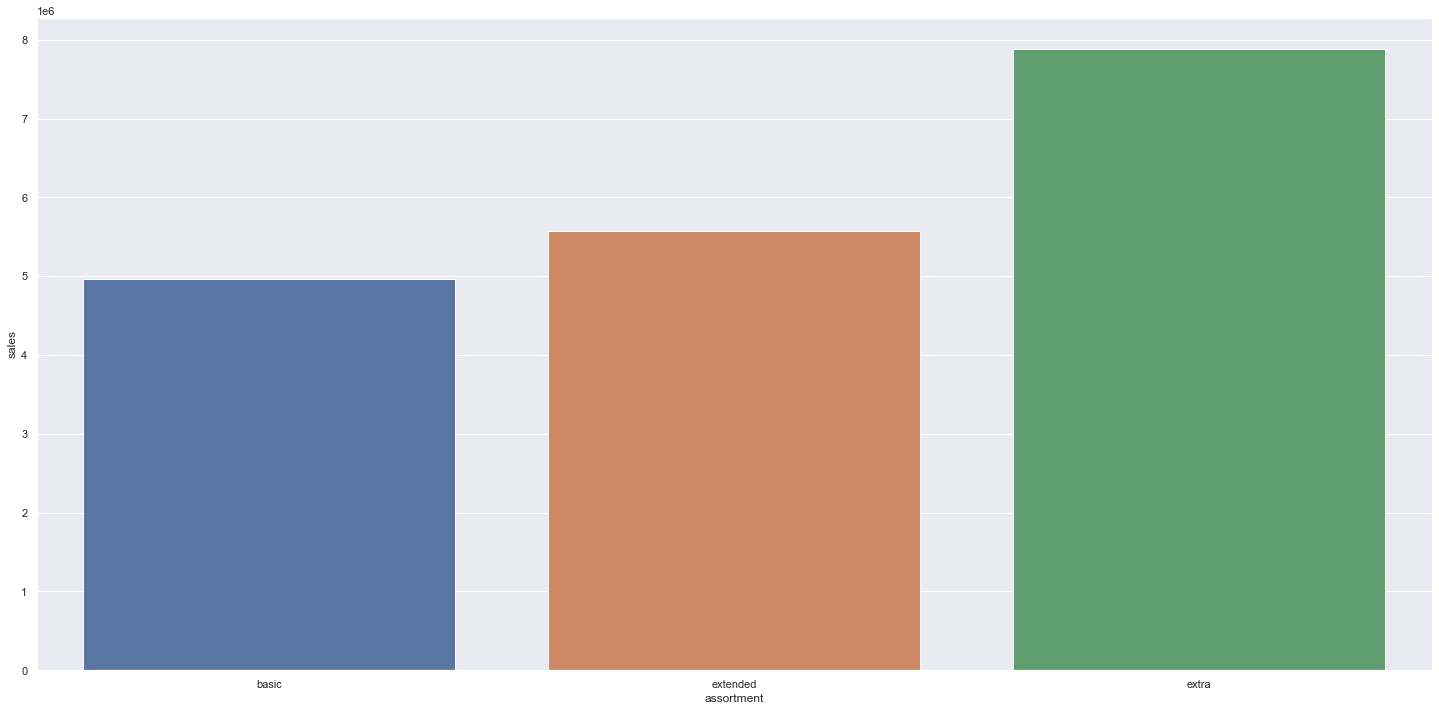

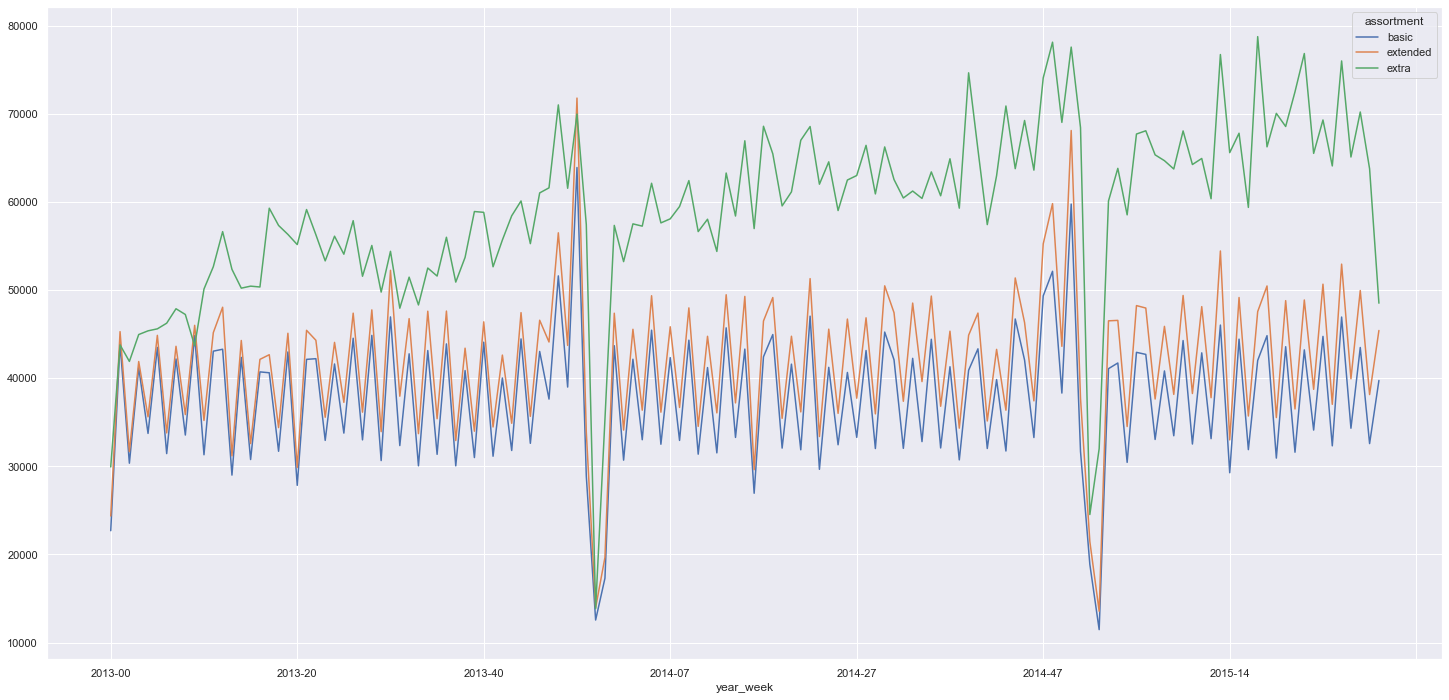

In [38]:
aux1 = df4[['assortment','sales','store']].groupby(['store','assortment']).sum().reset_index().groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data = aux1)  # shows average store sales by assortment

aux2 = df4[['year_week','assortment', 'sales','store']].groupby(['year_week','assortment','store']).sum().reset_index().groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values = 'sales').plot()


### **H2** Stores with more distant competitors should sell more.
**False** There is a correlation close to zero, but negative, which shows that the more distant they sell slightly less.

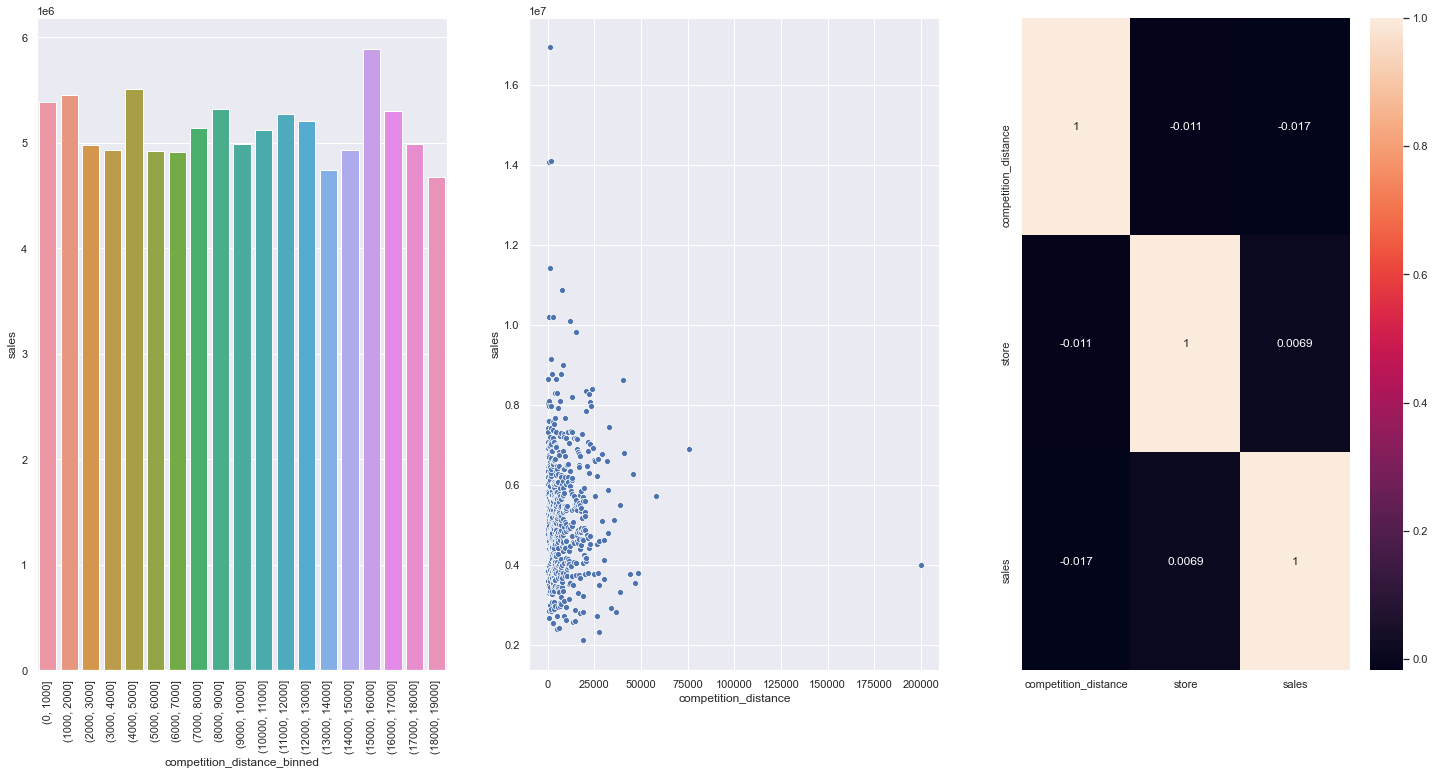

In [39]:
aux1 = df4[['competition_distance','sales','store']].groupby(['store','competition_distance']).sum().reset_index().groupby('competition_distance').mean().reset_index()

bi = list(np.arange(0,20000,1000))

aux1['competition_distance_binned'] = pd.cut(x = aux1['competition_distance'], bins=bi)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()

subplot(1,3,1)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation = 90);

subplot(1,3,2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True)

### **H3** Stores with older competitors should sell more.
**False** stores with older competitors sell slightly less.

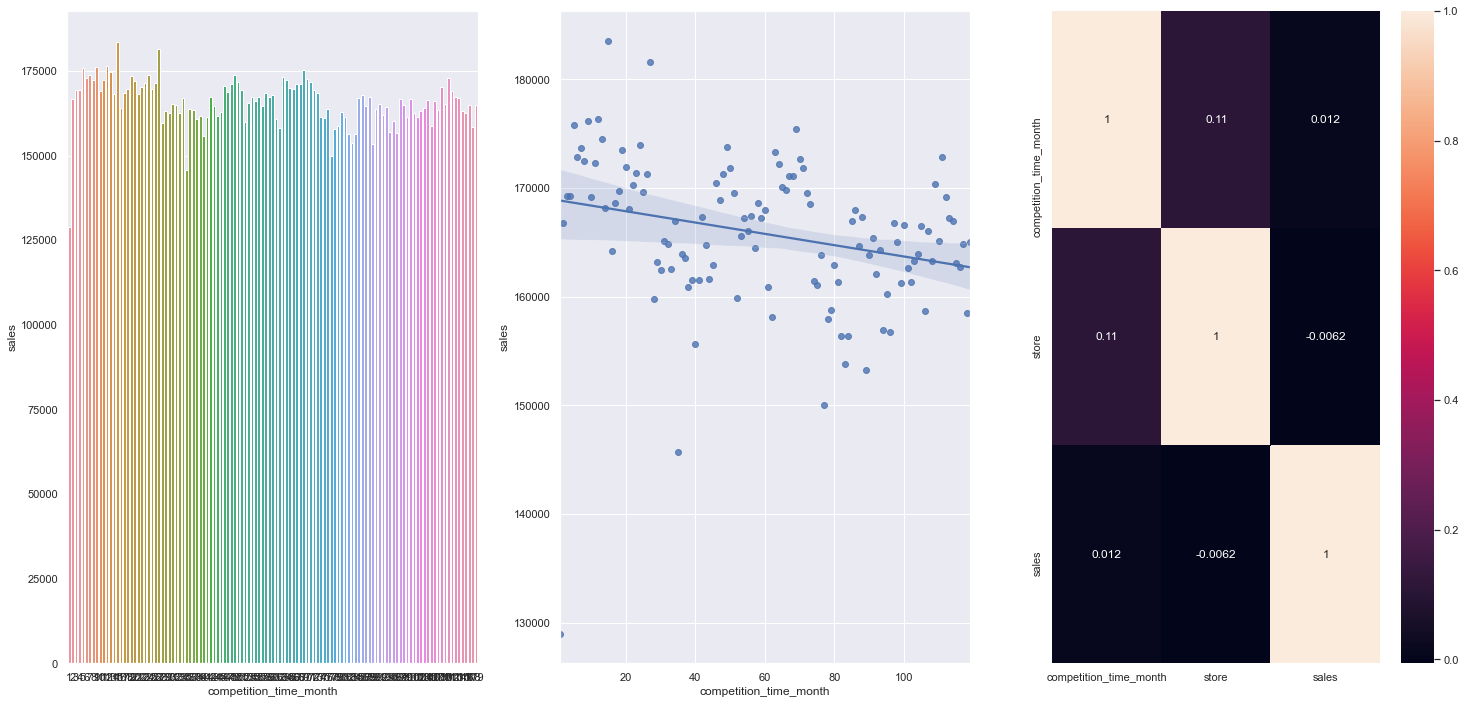

In [40]:


aux1 = df4[['competition_time_month', 'sales','store']].groupby(['store','competition_time_month']).sum().reset_index().groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] > 0)]

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month', y ='sales', data = aux2)
#plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data = aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H4.** Stores with active promotions for a longer time should sell more. 
**False** Stores with active promotions for longer sell less, after a certain period of promotion.



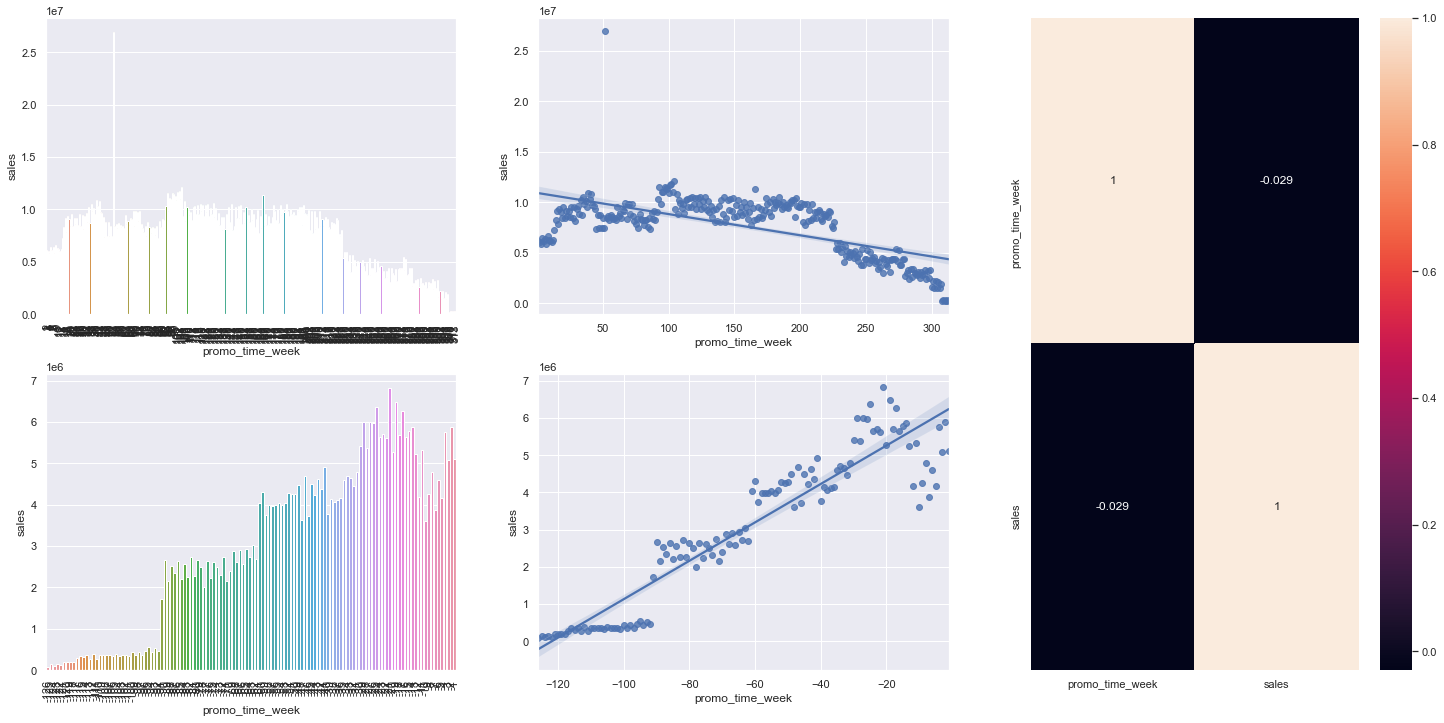

In [42]:
aux1 = df4[['promo_time_week', 'sales']].groupby ('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x = 'promo_time_week', y='sales', data=aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] <0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s>**H5.** Stores with more promotion days should sell more.</s>



### **H6.** Stores with more consecutive promotions should sell more.
**False** Stores with more consecutive promotions sell less

In [43]:
a = df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()
a.sort_values(by=['sales'], inplace=True)
a

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


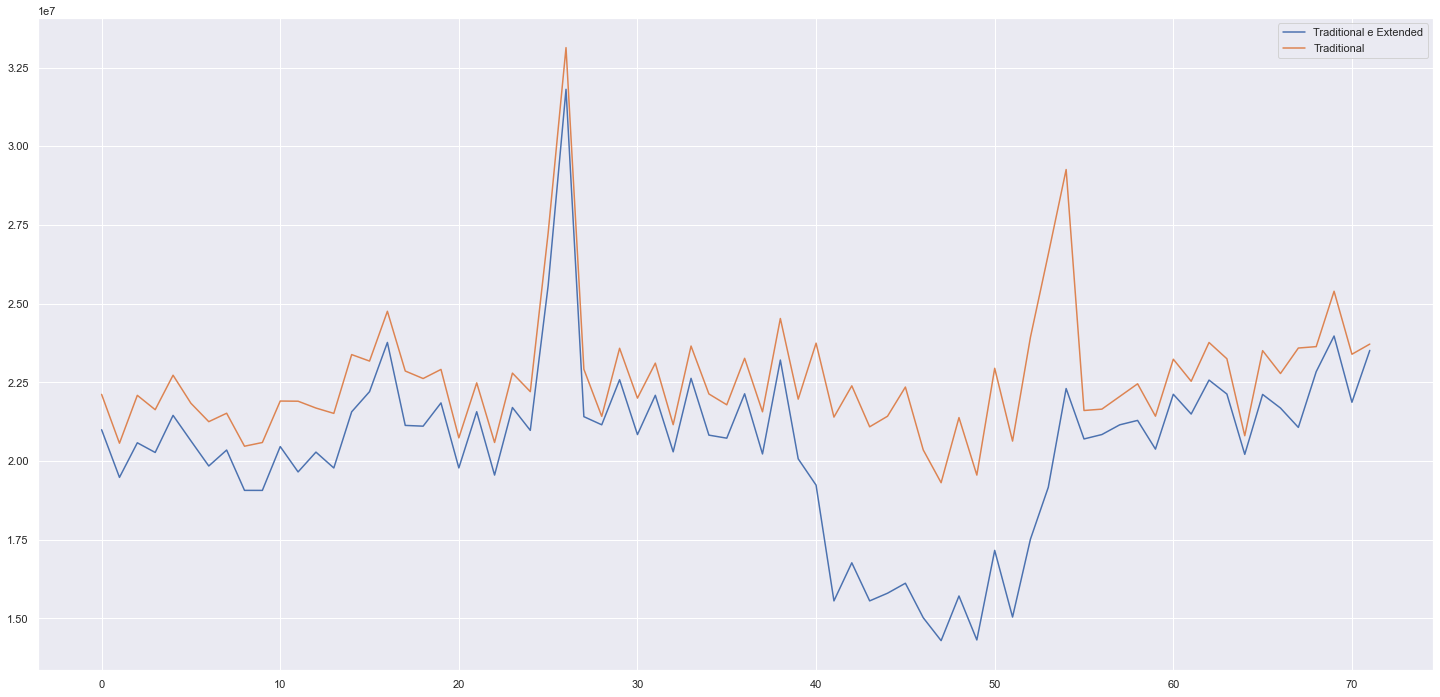

In [44]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Traditional e Extended', 'Traditional']);

### **H7.** Stores open during the Christmas holiday should sell more.
**False** Stores open during the Christmas holiday sell less than other holidays

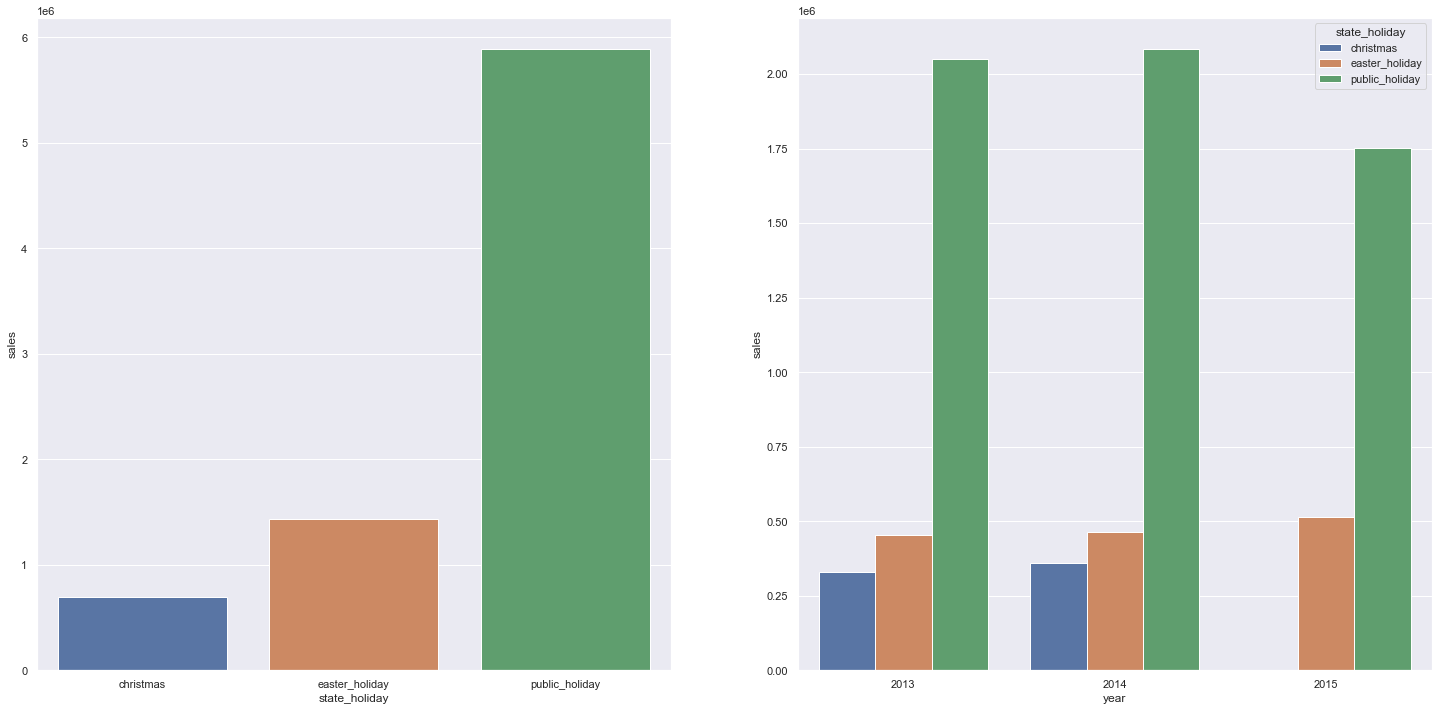

In [45]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales',hue = 'state_holiday', data = aux2);

### **H8.** Stores should sell more over the years.
**True**


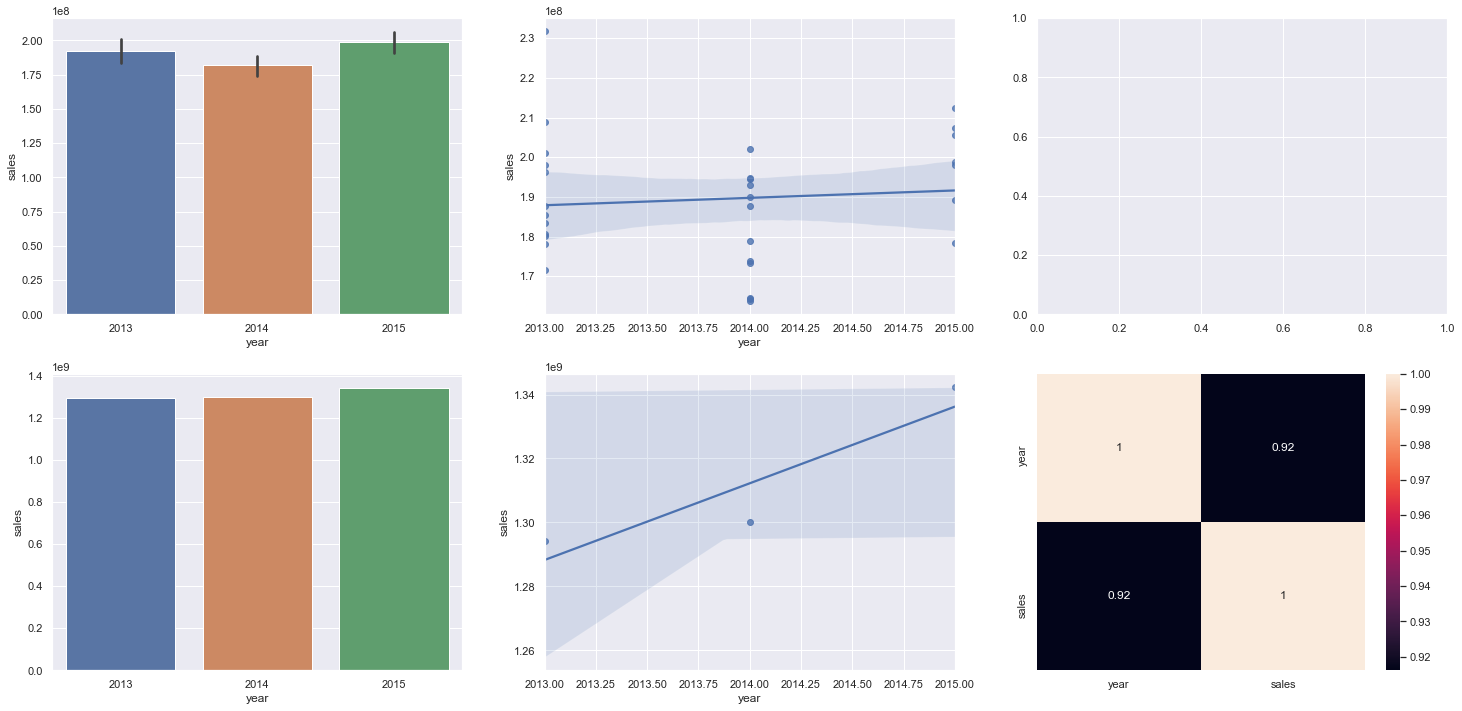

In [46]:
aux1 = df4[['month','sales','year']].groupby(['month','year']).sum().reset_index()

#average sale / month each year
plt.subplot(2,3,1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(2,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(2,3,3)


# total sales in each year up to the number of weeks we have in 2015
max_week = max(df4[df4['year'] == 2015 ]['week_of_year'])-1
aux2 = df4[df4['week_of_year'] <= max_week ][['year', 'sales']].groupby( 'year' ).sum().reset_index()


plt.subplot( 2, 3, 4 )
sns.barplot( x='year', y='sales', data=aux2 );

plt.subplot( 2, 3, 5 )
sns.regplot( x='year', y='sales', data=aux2 );

plt.subplot( 2, 3, 6 )
sns.heatmap( aux2.corr( method='pearson' ), annot=True );


### **H9.** Stores should sell more in the second half of the year.
**False** no major changes


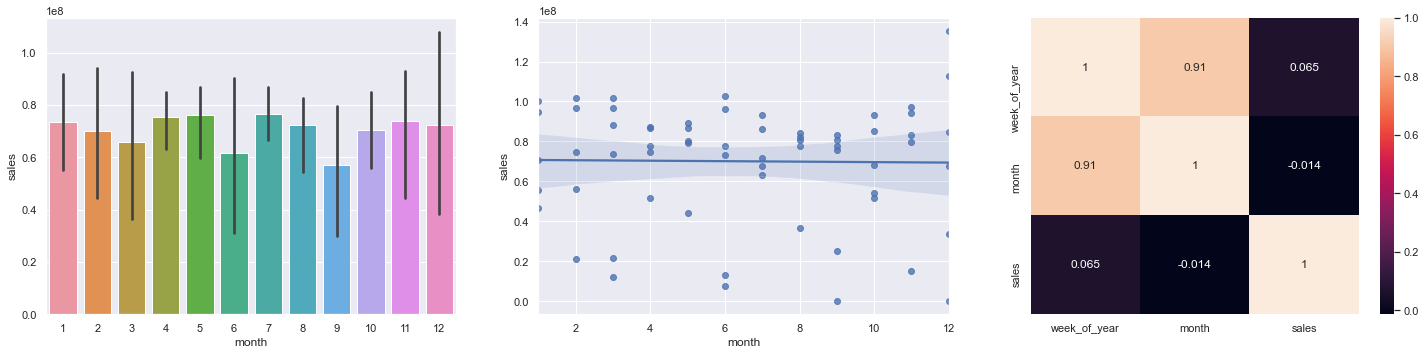

In [47]:
ax = df4[df4['year'] != 2015]
aux1 = ax[['week_of_year','sales','month']].groupby(['week_of_year','month']).sum().reset_index()

plt.subplot(2,3,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(2,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(2,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
#average sale / month during the years 2013 and 2014, 2015 does not have data from the 30th week of the year



In [48]:
aux2.head(10)

,year,sales
0,2013,1294305297
1,2014,1300114206
2,2015,1342268720


### **H10.** Stores should sell more after the 10th of each month
**False** sell less


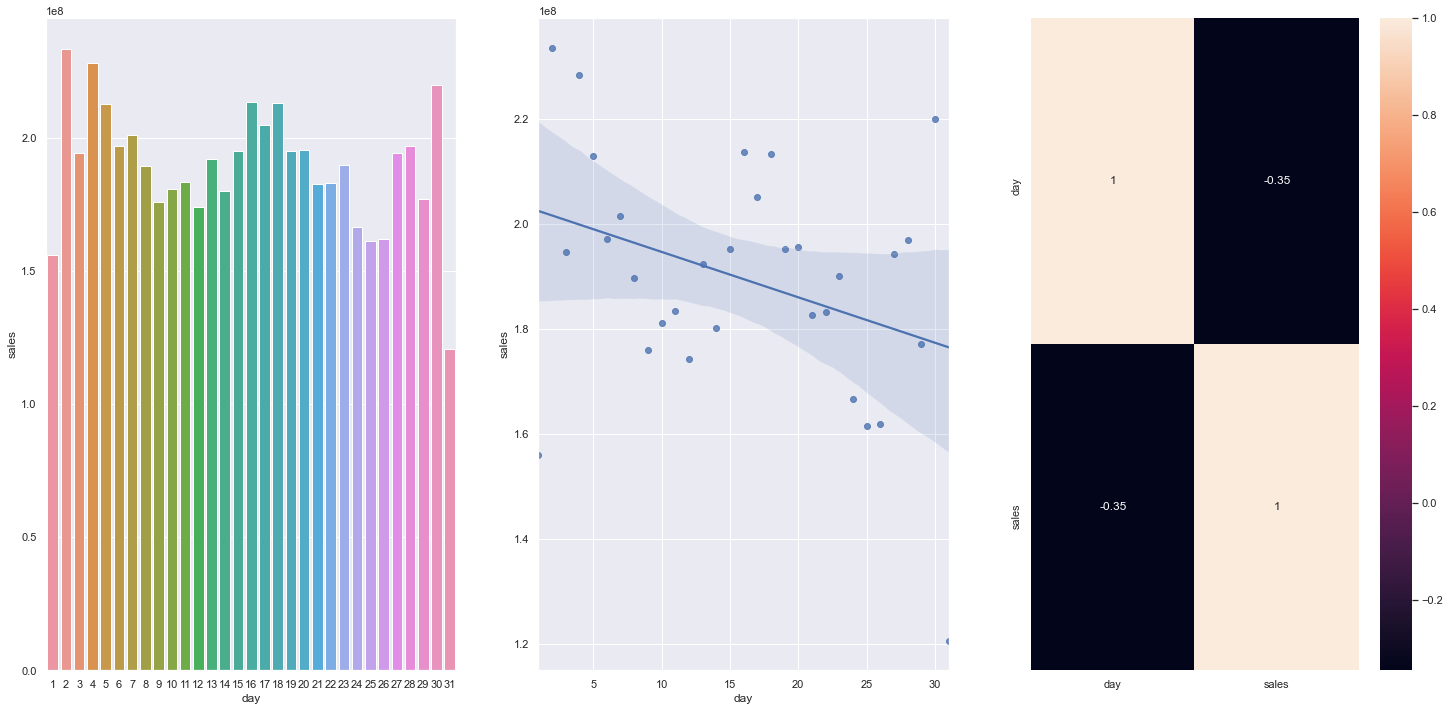

In [49]:
aux1 = df4[['sales','day']].groupby(['day']).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


### **H11.** Stores should sell less on weekends
**True**


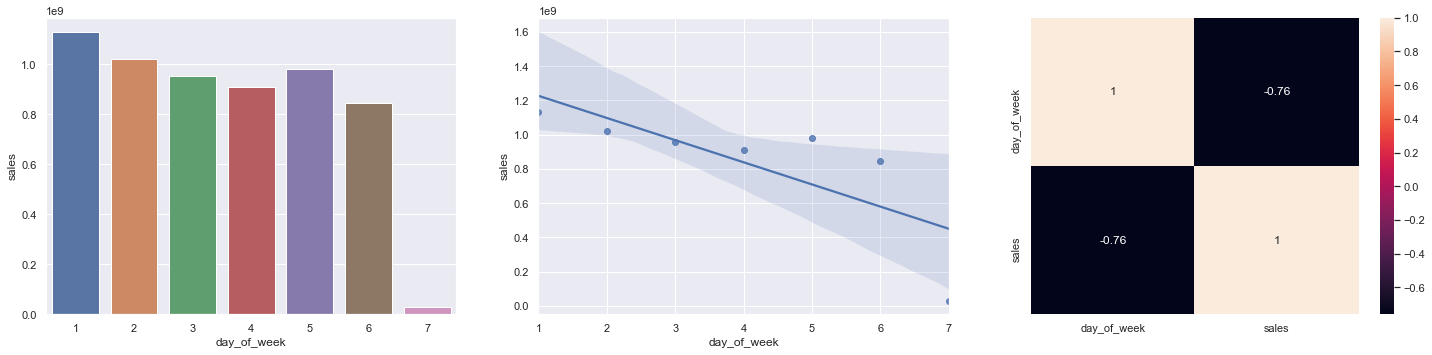

In [50]:
aux1 = df4[['sales','day_of_week']].groupby(['day_of_week']).sum().reset_index()

plt.subplot(2,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(2,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(2,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 4.2.1 Summary of hypotheses

In [51]:


tab = [['hypotheses', 'conclusion', 'relevance'],
        ['H1', 'True', 'Medium'],
        ['H2', 'False', 'Low'],
        ['H3', 'False', 'Medium'],
        ['H4', 'False', 'Medium'],
        ['H5', '-', '-'],
        ['H6', 'False', 'Medium'],
        ['H7', 'False', 'Medium'],
        ['H8', 'True', 'Low'],
        ['H9', 'False', 'Low'],
        ['H10', 'False', 'Low'],
        ['H11', 'True', 'High'],
     ]
print (tabulate (tab, headers = 'firstrow'))

hypotheses    conclusion    relevance
------------  ------------  -----------
H1            True          Medium
H2            False         Low
H3            False         Medium
H4            False         Medium
H5            -             -
H6            False         Medium
H7            False         Medium
H8            True          Low
H9            False         Low
H10           False         Low
H11           True          High


## 4.3 Multivariate analysis

### 4.3.1 Numerical Attributes

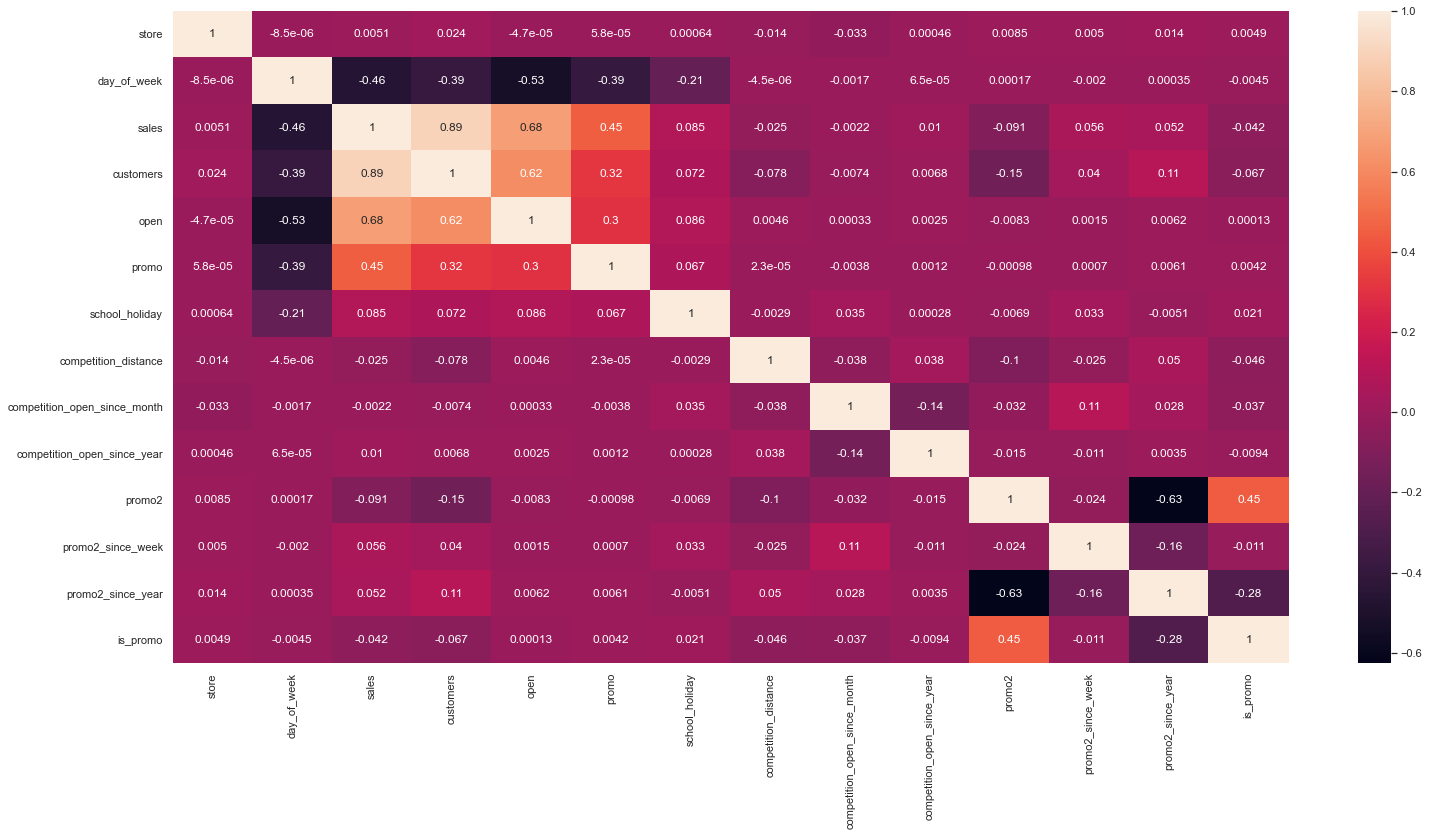

In [52]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

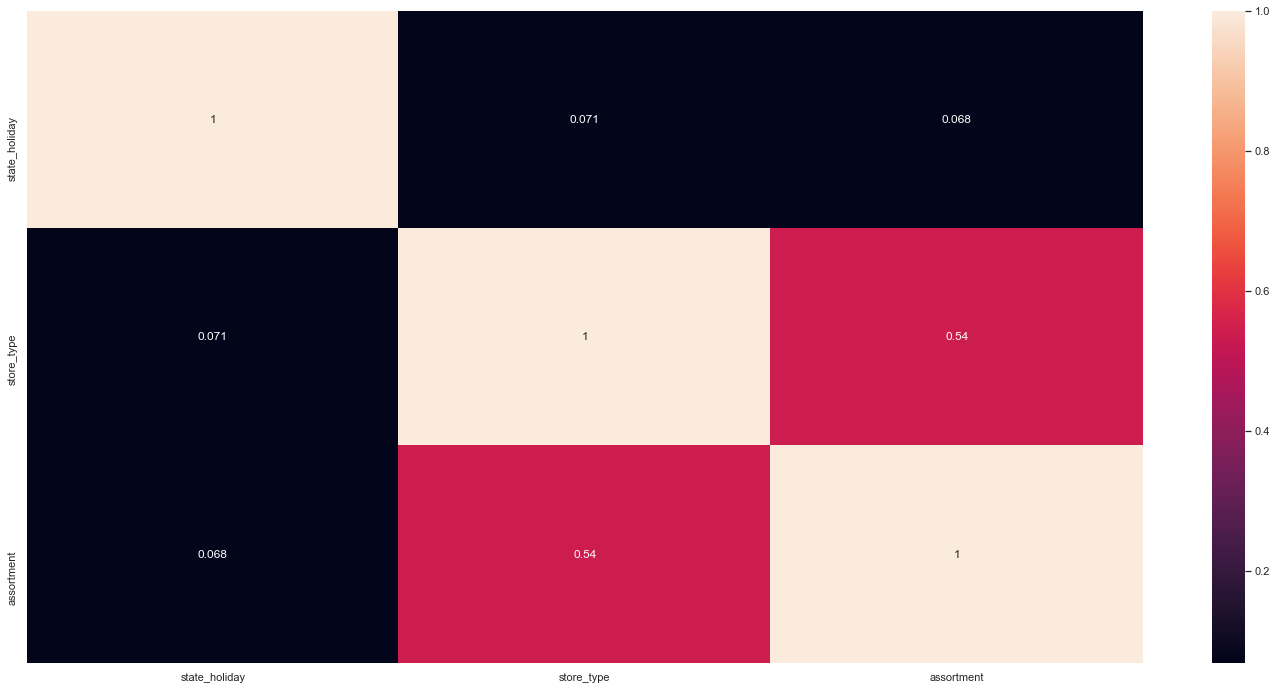

In [53]:
a = df4.select_dtypes(include = 'object')

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot = True);

# 5.0 Data Preparation

In [54]:
df5 = df4.copy()

## 5.1 Normalization

Observing the distributions of the numerical variables in 4.1.2, it is visible that none has a distribution close to normal, thus it would negatively affect normalization

## 5.2 Rescaling

In [55]:
a = df5.select_dtypes(include=['int64', 'float64'])

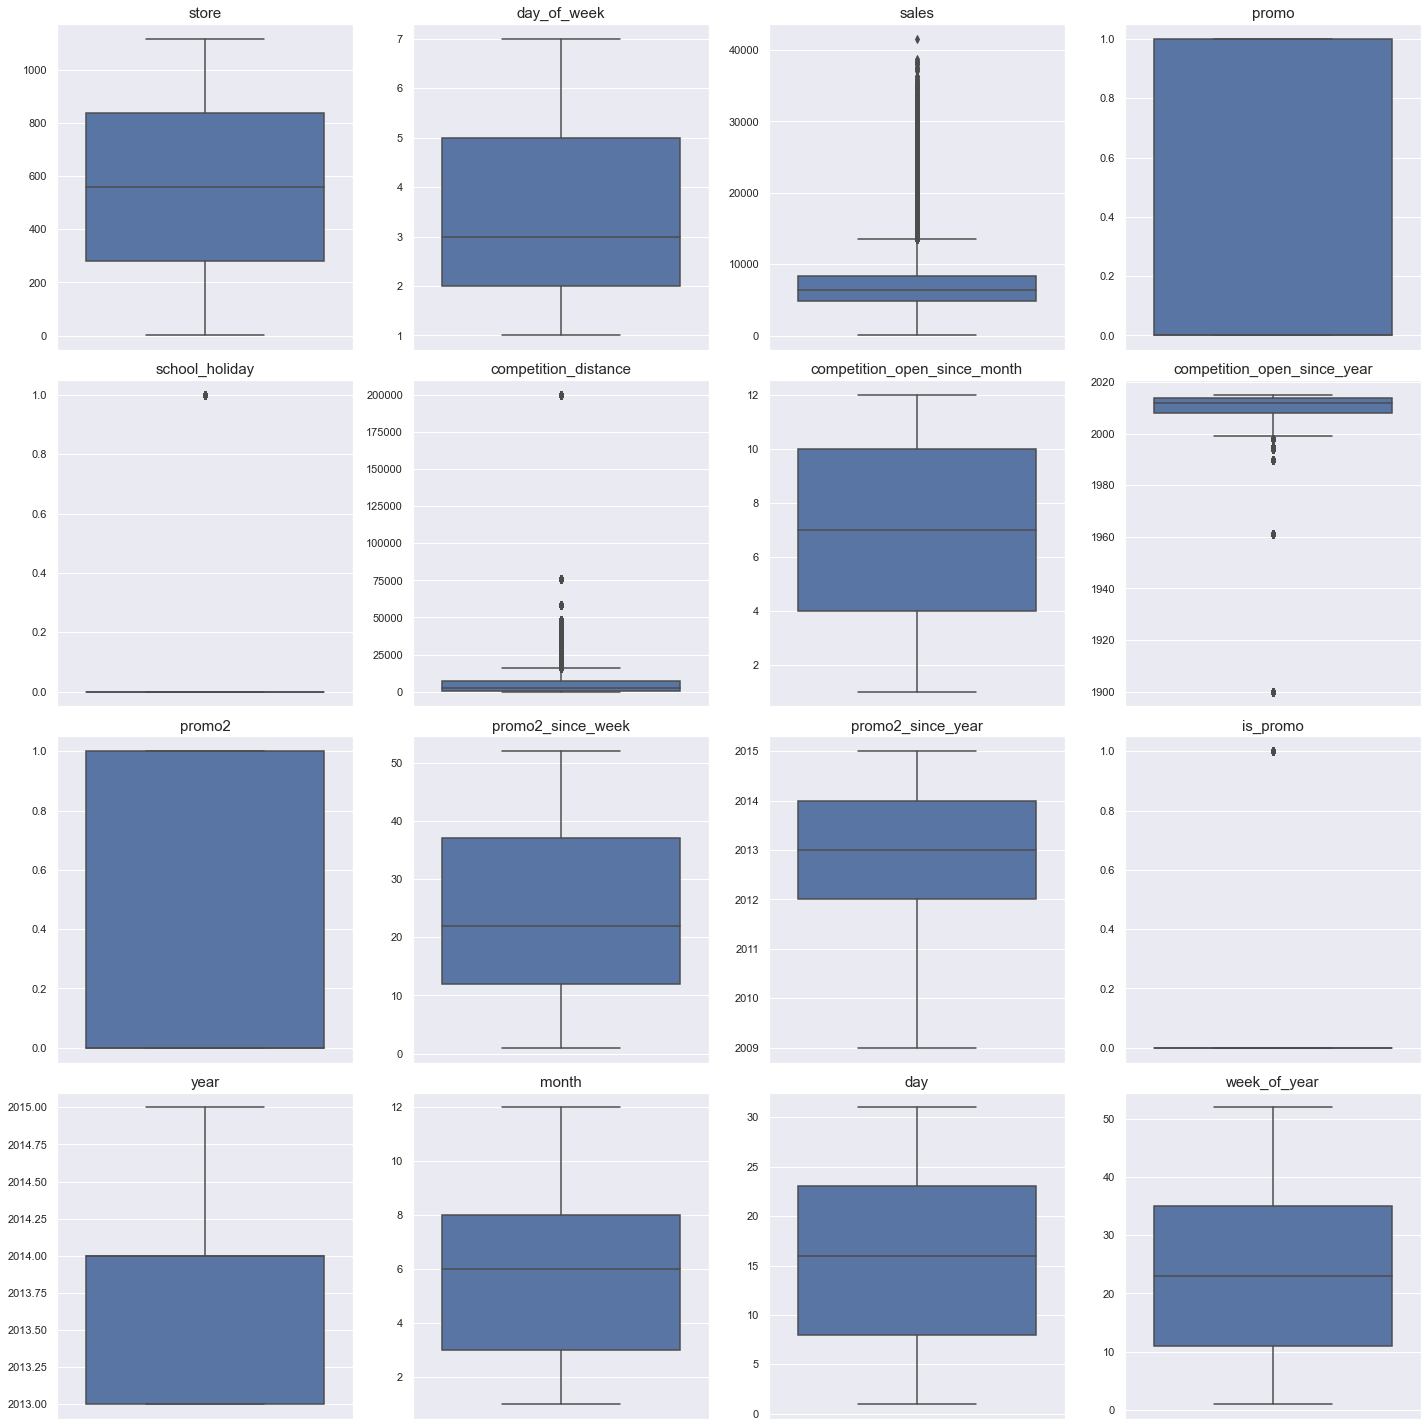

In [56]:
variables = a.columns.tolist()

f, axes = plt.subplots(4, 4, figsize = (20, 20))
for var, ax in zip(variables, f.axes):

  b = sns.boxplot(y = var, data = a, ax = ax)
  b.axes.set_title(var,fontsize = 15)
  b.set_ylabel("")

plt.tight_layout()
plt.show()

In [57]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## 5.3 Transformation

### 5.3.1 Encoding

In [58]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation


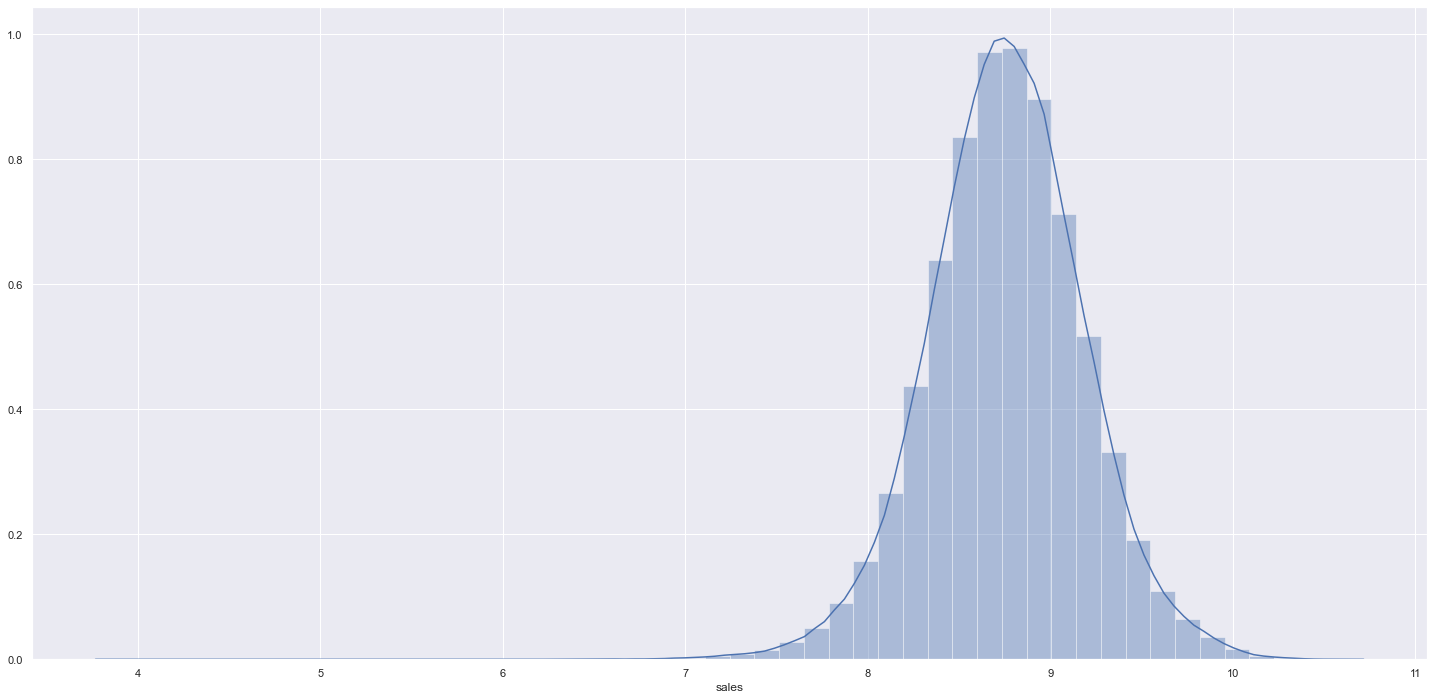

In [59]:
df5['sales'] = np.log1p(df5['sales'])
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [60]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )


In [61]:
df5.head(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 Feature Selection

In [62]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [63]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [64]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7) # já que quero testar 6 semanas a frente

Timestamp('2015-06-19 00:00:00')

In [65]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2 Boruta as feature selector

In [66]:

# training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs = -1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best features from boruta

In [67]:

#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date','sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [68]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin', # added
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin', # added
 'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modelling

In [69]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [134]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()


# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns ={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [135]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [136]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [137]:
# Model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [138]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [139]:
# Model
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train) # aumentar posteriormente se der (usa-se 2500 ou 3000)

# prediction
#yhat_rf = rf.predict(x_test)

# performance
#rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [140]:
#rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
#rf_result_cv

## 7.5 XGBoost Regressor

In [141]:
# model
#model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                              n_estimators=100, 
#                              eta=0.01, 
#                              max_depth=10, 
#                              subsample=0.7,
#                              colsample_bytree=0.9 ).fit( x_train, y_train )
#
# prediction
#yhat_xgb = model_xgb.predict( x_test )

# performance
#xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
#xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [142]:
#xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#xgb_result_cv

## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [143]:
#modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result,xgb_result])
#modelling_result.sort_values('RMSE')

<img src="img/7.6_single.png">

### Real Performance - Cross Validation

In [144]:
#modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
#modelling_result_cv

<img src="img/7.6_cross.png">

# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [145]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5


In [146]:
#final_result = pd.DataFrame()

#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

In [147]:
#final_result

<img src="img/final_result.png">

## 8.2 Final Model

In [148]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [149]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,664.974996,0.097529,957.774225


<img src="img/final_model.png">

# 9.0 Error Translation and Interpretation


# Overall performance


**MAE Error**: Mean Absolute Error (sum of all errors divided by N)

1 - Assigns equal weight to all errors

2 - Robust in the presence of Outliers

3 - Easy understanding by the business team

**MAPE Error**: Mean Absolute Percentage Error (MAE in percent)

1 - Shows how far the prediction is from the real value, on average, as a percentage.

2 - Used in the disclosure of results

3 - Cannot be used if the response variable contains 0 (MAPE = summation | y-yhat / y | / N)

**RMSE Error**: Root Mean Square Error (used instead of MAE when it is a more rigorous project)

1 - Assigns greater weight to larger errors

2 - Sensitive in the presence of Outliers

3 - Ideal for measuring the performance of ML models

**MPE Error**: Mean Percentage Error (good to know if it is overestimated or underestimated)

1 - Cannot be used to measure model performance

2 - Useful to understand if the model is underestimating or overestimating

3 - Cannot be used if the response variable contains 0

Negative: overestimating

positive: underestimating

### Summary:

**1 - Performance of the regression model: RMSE and MPE**

    Metrics to improve model performance
    
**2 - Performance of the model on the business: MAE, MAPE and MPE**

    Report metrics for the business team


In [150]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

<ipython-input-150-14002072d9da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
<ipython-input-150-14002072d9da>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1 Business Performance


In [151]:
df9_aux0 = df9[['store','date']].groupby( 'store' ).apply(lambda x: unique(x['date']).size).reset_index().rename( columns={0:'dias_com_vendas'})

# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux22 = pd.merge( df9_aux0, df9_aux1, how='inner', on='store' )
df9_aux3 = pd.merge( df9_aux22, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )
aaa = df9[['store', 'sales']].groupby( 'store' ).sum().reset_index()
df92 = pd.merge( df92, aaa, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']*df92['dias_com_vendas']
df92['best_scenario'] = df92['predictions'] + df92['MAE']*df92['dias_com_vendas']

# order columns
df92 = df92[['store','dias_com_vendas', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE','sales']]

In [152]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,dias_com_vendas,predictions,worst_scenario,best_scenario,MAE,MAPE,sales
291,292,19,104033.078125,40989.094482,167077.061768,3318.104402,0.565828,137966.0
908,909,23,238233.875000,62041.505371,414426.244629,7660.537810,0.520433,360069.0
875,876,23,203030.156250,112888.468994,293171.843506,3919.203794,0.305099,257556.0
721,722,37,353005.781250,279296.008301,426715.554199,1992.156026,0.268338,279296.0
594,595,37,400883.625000,272554.237305,529213.012695,3468.361830,0.242192,529213.0


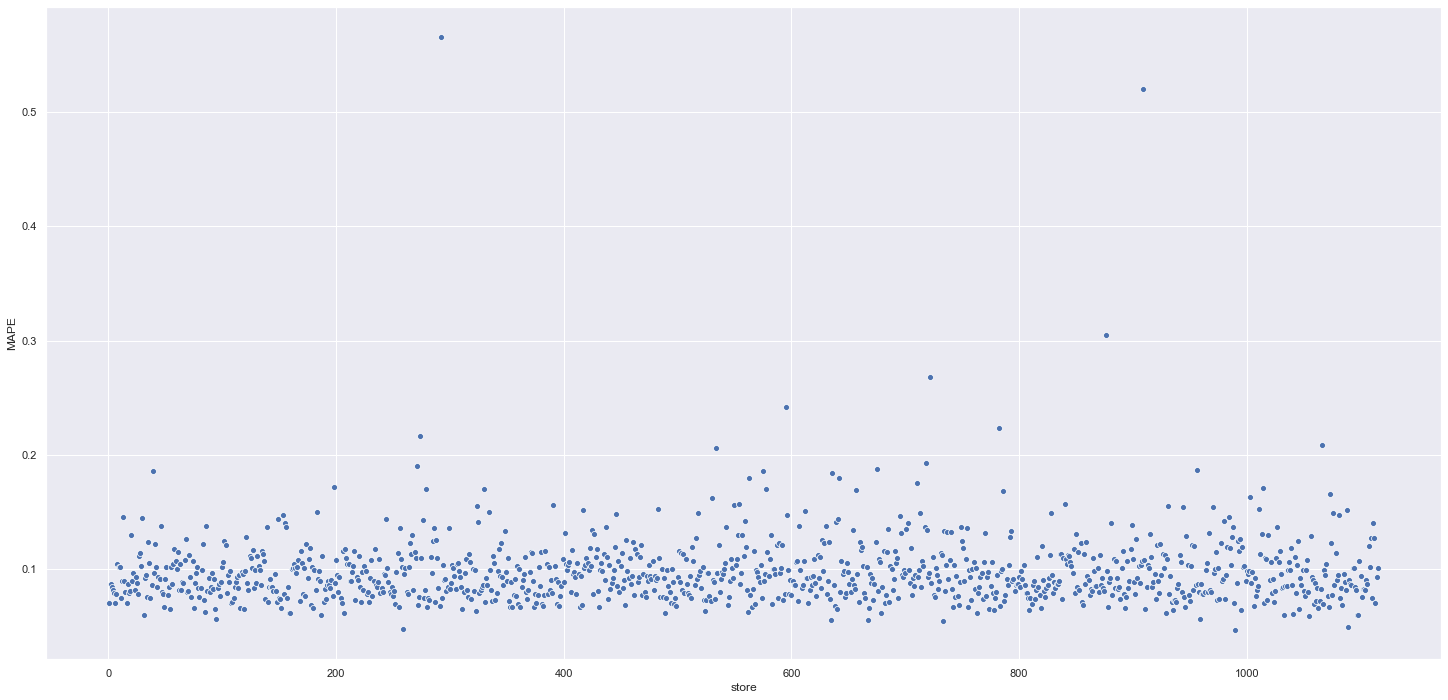

In [153]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

In [154]:
mpe = mean_percentage_error( np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
mpe

-0.0035453340649563925

As the MPE is negative, the results, on average, are overestimating the value of sales



## Total Performance

In [155]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$285,860,497.74"
1,worst_scenario,"R$258,333,192.80"
2,best_scenario,"R$313,387,802.68"


## 9.3 Machine Learning Performance

In [156]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<ipython-input-156-0c99df7e7a2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
<ipython-input-156-0c99df7e7a2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


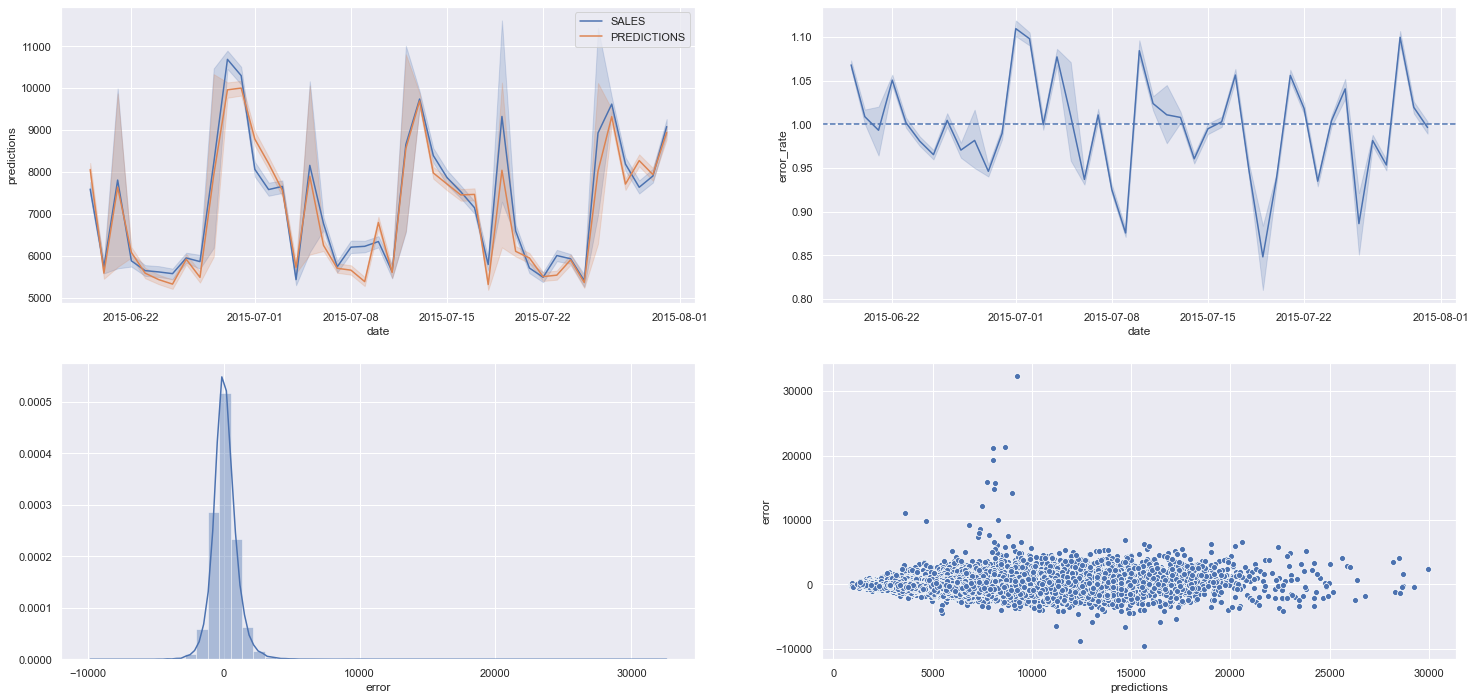

In [157]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0 Deploy Model to Production

In [158]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( 'B:/Projetos/ML/model/model_rossmann.pkl', 'wb' ) )

## 10.1 Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='B:/Projetos/ML/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'B:/Projetos/ML/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 10.3 API Tester

In [1]:
import requests
import pandas as pd

In [9]:


# loading test dataset
df10 = pd.read_csv( 'B:/Projetos/ML/data/test.csv' )

# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 53] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [10]:
# API Call
#url = 'http://127.0.0.1:5000/rossmann/predict' 
url = 'https://rossmann-predicao-ml-2.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [11]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$306,210.55 in the next 6 weeks
Store Number 23 will sell R$230,807.19 in the next 6 weeks
Store Number 53 will sell R$250,994.33 in the next 6 weeks


## Telegram API

In [ ]:
import pandas as pd
import json
import requests
import os

from flask import Flask, request, Response

TOKEN = '1591900929:AAH-FBaiMvdqrFWD-ZUS39boahN7lavFYSQ'

# INFO
#https://api.telegram.org/bot1591900929:AAH-FBaiMvdqrFWD-ZUS39boahN7lavFYSQ/getMe
        
# get update
#https://api.telegram.org/bot1591900929:AAH-FBaiMvdqrFWD-ZUS39boahN7lavFYSQ/getUpdates
        
# send message
#https://api.telegram.org/bot1591900929:AAH-FBaiMvdqrFWD-ZUS39boahN7lavFYSQ/sendMessage?chat_id=361802176&text=va dormir

#361802176
        
    
def send_message(chat_id, text):
    url = 'https://api.telegram.org/bot{}/'.format(TOKEN)
    url = url + 'sendMessage?chat_id={}/'.format( chat_id )
    
    r = requests.post(url, json={'text':text})
    print( 'Status Code {}'.format( r.status_code ) )
    
    return None
    
def load_dataset(store_id):
    # loading test dataset
    df10 = pd.read_csv( 'test.csv' )
    df_store_raw = pd.read_csv( 'store.csv' )

    # merge test dataset + store
    df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

    # choose store for prediction
    df_test = df_test[df_test['Store']== store_id]

    if not df_test.empty:
    
        # remove closed days
        df_test = df_test[df_test['Open'] != 0]
        df_test = df_test[~df_test['Open'].isnull()]
        df_test = df_test.drop( 'Id', axis=1 )

        # convert Dataframe to json
        data = json.dumps( df_test.to_dict( orient='records' ) )
    
    else:
        data = 'error'
    
    return data

def predict(data):

    # API Call
    url = 'https://rossmann-predicao-ml-2.herokuapp.com/rossmann/predict'
    header = {'Content-type': 'application/json' } 
    data = data

    r = requests.post( url, data=data, headers=header )
    print( 'Status Code {}'.format( r.status_code ) )

    d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
    
    return d1

def parse_message(message):
    chat_id = message['message']['chat']['id']
    store_id = message['message']['text']
    
    store_id = store_id.replace('/','')
    
    try:
        store_id = int(store_id)
        
    except ValueError:
        store_id = 'error'
        
    
    return chat_id, store_id
    
# API initialize
app = Flask( __name__ )

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        message = request.get_json()
        
        chat_id, store_id = parse_message( message )
        
        if store_id != 'error':
            # loading data
            data = load_dataset(store_id)
            
            if data != 'error':
                # prediction
                d1 = predict(data)
                # calculation
                d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
                # send message
                msg = 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
                            d2['store'].values[0], 
                            d2['prediction'].values[0] ) 

                send_message(chat_id, msg)

                return Response('OK', status=200)
            
            else:
                send_message(chat_id, 'Store not available')
                return Response('OK', status = 200)
            
        else:       
            send_message(chat_id, 'Store ID is Wrong')
            return Response('OK', status=200)
        
    else:
        return '<h1> Rossmann Telegram BOT </h1>'

if __name__ == '__main__':
    port = int(os.environ.get('PORT', 33507))
    app.run( host = '0.0.0.0', port = port)